## MindBERT
**by Syed Faizan**

An application designed with a deep learning backend, involving the finetuning of BERT for identifying the mental state by analysing natural language inputs.
This can aid in computational psychiatric screening, employee mental health redressal, psychiatric and psychological research and academic educational purposes.



In [ ]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset


In [ ]:
data = pd.read_csv('/content/mindbertdata.csv')
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
data.isna().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [ ]:
data.dropna(inplace=True)
data.isna().sum()

,0
Unnamed: 0,0
statement,0
status,0


In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


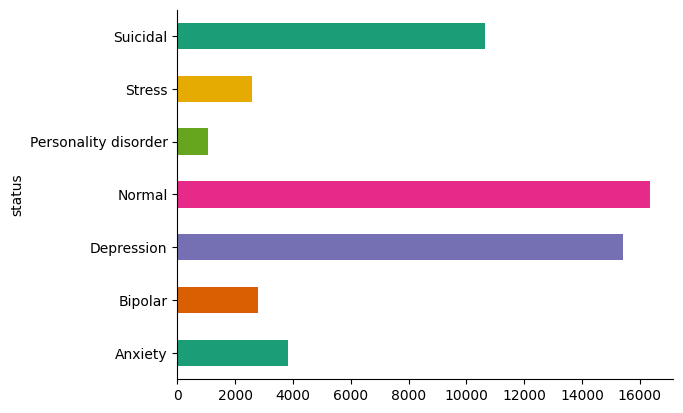

In [ ]:
#  status visualized

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
  # lower the case
  text = text.lower()
  # remove special characters
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  # tokenization
  words = text.split()
  # remove stop words
  words = [word for word in words if word not in stop_words]
  # lemmatization
  words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(words)


In [ ]:
clean_text(data['statement'][3])

'ive shifted focus something else im still worried'

In [ ]:
data['statement'] = data['statement'].apply(clean_text)

In [ ]:
data['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


Data Balancing


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(data[['statement']], data['status'])

data = pd.concat([X_resampled, y_resampled], axis=1)
data['status'].value_counts()

,count
status,
Anxiety,16343
Normal,16343
Depression,16343
Suicidal,16343
Stress,16343
Bipolar,16343
Personality disorder,16343


Encoding

In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])
data.head()

,statement,status,label
0,oh gosh,Anxiety,0
1,trouble sleeping confused mind restless heart ...,Anxiety,0
2,wrong back dear forward doubt stay restless re...,Anxiety,0
3,ive shifted focus something else im still worried,Anxiety,0
4,im restless restless month boy mean,Anxiety,0


Train test split early to prevent data leakage


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2, random_state=42)

Tokenization with BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length= 200, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True,max_length= 200, return_tensors='pt')




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings

{'input_ids': tensor([[ 101, 2253, 3058,  ...,    0,    0,    0],
        [ 101, 5364,  102,  ...,    0,    0,    0],
        [ 101, 2113, 2296,  ...,    0,    0,    0],
        ...,
        [ 101, 2126, 2110,  ...,    0,    0,    0],
        [ 101, 2376, 3835,  ...,    0,    0,    0],
        [ 101, 3071, 2105,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})

In [ ]:
train_dataset[2]

{'input_ids': [101,
  2113,
  2296,
  2051,
  6634,
  2886,
  10825,
  2132,
  11891,
  2210,
  2518,
  2191,
  2514,
  2066,
  4485,
  3087,
  2842,
  2131,
  13330,
  5236,
  2518,
  2066,
  10047,
  2130,
  9421,
  3110,
  5506,
  3566,
  2066,
  2123,
  2102,
  2113,
  2425,
  2619,
  2740,
  10089,
  2123,
  2102,
  2298,
  2157,
  1057,
  5603,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Fine tuning the model

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: drsyedfaizan1987 (drsyedfaizan1987-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00


In [ ]:
import evaluate


# Load Accuracy Metric
metric = evaluate.load("accuracy")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    evaluation_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2,    # Simulate larger batch size if GPU memory is limited
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics

)

# Fine-tuning the model
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.359400,0.285864,0.896071
2,0.210500,0.224632,0.920327
3,0.177800,0.217146,0.928281
4,0.089200,0.249640,0.932346
5,0.087600,0.282782,0.933875


TrainOutput(global_step=14300, training_loss=0.2280898212386178, metrics={'train_runtime': 3942.3733, 'train_samples_per_second': 116.072, 'train_steps_per_second': 3.627, 'total_flos': 4.7033212512e+16, 'train_loss': 0.2280898212386178, 'epoch': 5.0})

Evaluation

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)


In [ ]:
# Classification Report
print(classification_report(test_labels, predictions, target_names=label_encoder.classes_))



                      precision    recall  f1-score   support

             Anxiety       0.98      0.99      0.99      3375
             Bipolar       0.99      1.00      0.99      3214
          Depression       0.80      0.77      0.78      3274
              Normal       0.97      0.93      0.95      3325
Personality disorder       0.99      1.00      1.00      3241
              Stress       0.96      1.00      0.98      3209
            Suicidal       0.80      0.82      0.81      3243

            accuracy                           0.93     22881
           macro avg       0.93      0.93      0.93     22881
        weighted avg       0.93      0.93      0.93     22881



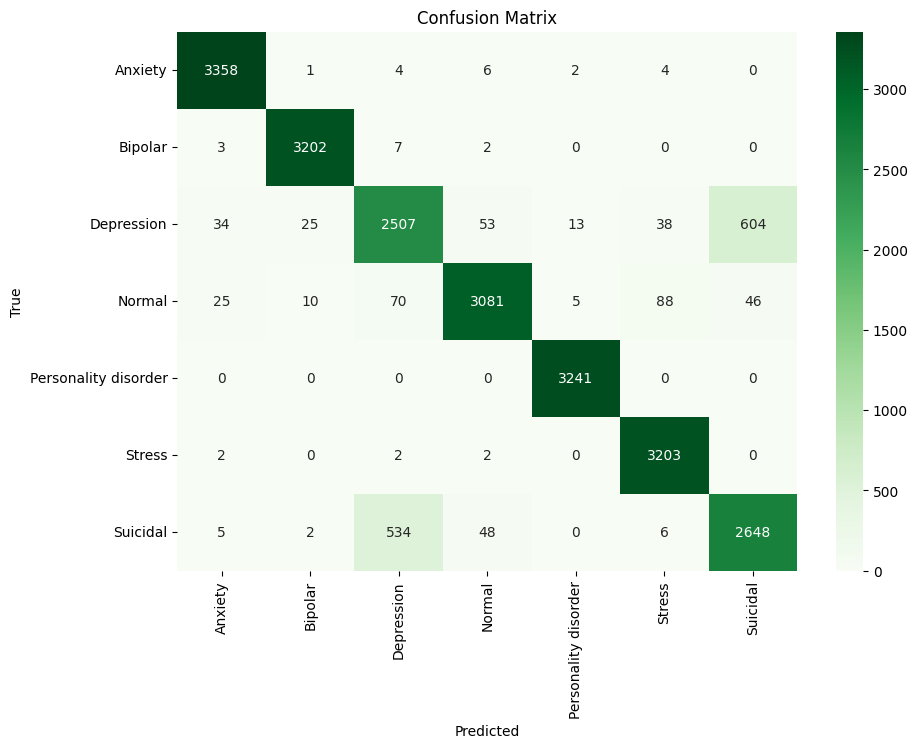

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
trainer.save_model('./mindbert')
tokenizer.save_pretrained('./mindbert')

import pickle
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('./mindbert')
model = AutoModelForSequenceClassification.from_pretrained('./mindbert')

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

In [ ]:
# Detection System
def detect_anxiety(text):
    cleaned_text = clean_text(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Bipolar

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Depression

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Normal

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Depression

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Depression

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



In [ ]:
import shutil
from google.colab import files
from transformers import BertTokenizer

# Step 1: Define paths to save the trained model and tokenizer
model_save_path = "/content/mindbert"  # Folder where model will be saved
tokenizer_save_path = model_save_path  # Save tokenizer in the same folder

# Step 2: Save the trained model and tokenizer
trainer.save_model(model_save_path)

# Ensure tokenizer is defined before saving
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.save_pretrained(tokenizer_save_path)

# Step 3: Create a zip file containing the saved model and tokenizer
zip_file_path = "/content/mindbert"  # This is the directory to zip
zip_output_path = "/content/mindbert_model"  # Name of the final zip file

# Zip the model folder
shutil.make_archive(zip_output_path, 'zip', root_dir=model_save_path)

# Step 4: Download the zip file
files.download(f"{zip_output_path}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!rsync -av --exclude='/content/drive' /content/ /content/drive/MyDrive/colab_backup/


sending incremental file list
./
.config/
.config/configurations/
.config/logs/
.config/logs/2025.02.27/
drive/.Encrypted/MyDrive/.ipynb_checkpoints (1)/
drive/.Encrypted/MyDrive/Colab Notebooks (1)/
drive/.Encrypted/MyDrive/colab_backup (1)/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/.ipynb_checkpoints/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/Colab Notebooks/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/colab_backup/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/colab_backup/drive/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/colab_backup/drive/.Encrypted/
drive/.Encrypted/MyDrive/colab_backup (1)/drive/.Encrypted/MyDrive/colab_backup/drive/.Encrypted/MyDrive/
drive/.Encrypted/MyDrive/colab_backup